# Image Inference

In [1]:
import matplotlib.pyplot as plt

In [ ]:
import os
import cv2
import torch
import subprocess
import platform
import tqdm.autonotebook as tqdm

import numpy as np
import gradio as gr

from basicsr.utils import img2tensor, tensor2img
from basicsr.utils.registry import ARCH_REGISTRY
from torchvision.transforms.functional import normalize
from concurrent.futures import ThreadPoolExecutor


# Custom Modules
import audio
import file_check
import preprocess_mp as pmp
import model_loaders as ml

# Global Variables
TEMP_DIRECTORY = file_check.TEMP_DIR
MEDIA_DIRECTORY = file_check.MEDIA_DIR
NPY_FILES_DIRECTORY = file_check.NPY_FILES_DIR
OUTPUT_DIRECTORY = file_check.OUTPUT_DIR

file_check.perform_check()

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [ ]:
# ------------------ set up CodeFormer restorer -------------------
net = ARCH_REGISTRY.get('CodeFormer')(dim_embd=512, codebook_size=1024, n_head=8, n_layers=9, 
                                        connect_list=['32', '64', '128', '256']).to(device)

# ckpt_path = 'weights/CodeFormer/codeformer.pth'
ckpt_path = file_check.CODEFORMERS_MODEL_PATH
checkpoint = torch.load(ckpt_path)['params_ema']
net.load_state_dict(checkpoint)
net.eval()

In [ ]:
# Perform checks to ensure that all required files are present
file_check.perform_check()

###################################################################################################################################################

frame_path = r"E:\Lip_Wise_GFPGAN\_testData\Inputs\test1.png"
audio_path = r'E:\Lip_Wise_GFPGAN\_testData\Inputs\a_for_apple.m4a'
mel_step_size = 16
fps = 25

fig = plt.figure(figsize=(10, 10))

###################################################################################################################################################

# Get input type
input_type, img_ext = file_check.get_file_type(frame_path)
if input_type != "image":
    raise Exception("Input file is not an image. Try again with an image file.")

# Get audio type
audio_type, aud_ext = file_check.get_file_type(audio_path)
if audio_type != "audio":
    raise Exception("Input file is not an audio.")
if aud_ext != "wav":
    print("Audio file is not a wav file. Converting to wav...")
    # Convert audio to wav
    command = 'ffmpeg -y -i {} -strict -2 {}'.format(audio_path, os.path.join(MEDIA_DIRECTORY, 'aud_input.wav'))
    subprocess.call(command, shell=True)
    audio_path = os.path.join(MEDIA_DIRECTORY, 'aud_input.wav')

# Check for cuda
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(f'Using {device} for inference.')

# Generate audio spectrogram
print("Generating audio spectrogram...")
wav = audio.load_wav(audio_path, 16000)
mel = audio.melspectrogram(wav)

mel_chunks = []
#The mel_idx_multiplier aligns audio chunks with video frames for consistent processing and analysis.
mel_idx_multiplier = 80./fps
i = 0
while 1:
    start_idx = int(i * mel_idx_multiplier)
    if start_idx + mel_step_size > len(mel[0]):
        mel_chunks.append(mel[:, len(mel[0]) - mel_step_size:])
        break
    mel_chunks.append(mel[:, start_idx : start_idx + mel_step_size])
    i += 1

print(f"Length of mel chunks: {len(mel_chunks)}")

# Create media_preprocess object and helper object
processor = pmp.model_processor()

# Read image
frame = cv2.imread(frame_path)
height, width, _ = frame.shape

#######################################################################
a = fig.add_subplot(3, 3, 1)
a.imshow(frame[:, :, ::-1])
a.set_title('Original Image')
a.axis('off')
#######################################################################

# Get face landmarks
print("Getting face landmarks...")
processor.detect_for_image(frame.copy())

# Create face helper object from landmarks
helper = pmp.FaceHelpers(image_mode=True)

# extract face from image
print("Extracting face from image...")
extracted_face, original_mask = helper.extract_face(frame.copy())

#######################################################################
b = fig.add_subplot(3, 3, 2)
b.imshow(extracted_face[:, :, ::-1])
b.set_title('extracted_face')
b.axis('off')
#######################################################################

# warp and align face
print("Warping and aligning face...")
aligned_face, rotation_matrix = helper.alignment_procedure(extracted_face)

#######################################################################
c = fig.add_subplot(3, 3, 3)
c.imshow(aligned_face[:, :, ::-1])
c.set_title('aligned_face')
c.axis('off')

print(aligned_face.shape)
#######################################################################

# Crop face
print("Cropping face...")
cropped_face, bbox = helper.crop_extracted_face(aligned_face, rotation_matrix)

#######################################################################
d = fig.add_subplot(3, 3, 4)
d.imshow(cropped_face[:, :, ::-1])
d.set_title('cropped_face')
d.axis('off')
#######################################################################

# Store cropped face's height and width
cropped_face_height, cropped_face_width, _ = cropped_face.shape

# Generate data for inference
gen = helper.gen_data_image_mode(cropped_face, mel_chunks)

# Load wav2lip model
w2l_model = ml.load_wav2lip_model()

# Load GFPGAN model
gfpgan = ml.load_gfpgan_model()
gfpgan = gfpgan.to(device)

# Initialize video writer
out = cv2.VideoWriter(os.path.join(MEDIA_DIRECTORY, 'temp.mp4'), cv2.VideoWriter_fourcc(*'mp4v'), fps, (width, height))

# Feed to model:
for i, (img_batch, mel_batch) in enumerate(gen):
    img_batch = torch.FloatTensor(np.transpose(img_batch, (0, 3, 1, 2))).to(device)
    mel_batch = torch.FloatTensor(np.transpose(mel_batch, (0, 3, 1, 2))).to(device)

    with torch.no_grad():
        dubbed_faces = w2l_model(mel_batch, img_batch)
    
    dubbed_faces = dubbed_faces.cpu().numpy().transpose(0, 2, 3, 1) * 255.

    for i, d in enumerate(dubbed_faces):
        d = cv2.resize(d.astype(np.uint8) / 255., (512, 512), interpolation=cv2.INTER_CUBIC)
        ################################################################################################
        # e = fig.add_subplot(3, 3, 5+i)
        # e.imshow(d[:, :, ::-1])
        # e.set_title('dubbed_face')
        # e.axis('off')

        # plt.show()
        ################################################################################################
        dubbed_face_t = img2tensor(d, bgr2rgb=True, float32=True)
        normalize(dubbed_face_t, (0.5, 0.5, 0.5), (0.5, 0.5, 0.5), inplace=True)
        dubbed_face_t = dubbed_face_t.unsqueeze(0).to(device)
        
        try:
            # output = gfpgan(dubbed_face_t, return_rgb=False, weight=0.5)[0] # for GFPGANv1
            with torch.no_grad():
                output = net(dubbed_face_t, w=0.5, adain=True)[0] # for CodeFormer
                restored_face = tensor2img(output.squeeze(0), rgb2bgr=True, min_max=(-1, 1))
            del output
            torch.cuda.empty_cache()
        except RuntimeError as error:
            print(f'\tFailed inference for GFPGAN: {error}.')
            restored_face = d
        
        restored_face = restored_face.astype(np.uint8)

        # Warp face back to original pose
        
        processed_face = cv2.resize(restored_face, (cropped_face_width, cropped_face_height), interpolation=cv2.INTER_LANCZOS4)
        processed_ready = helper.paste_back_black_bg(processed_face, bbox, extracted_face)
        ready_to_paste = helper.unwarp_align(processed_ready, rotation_matrix)
        restored_image = helper.paste_back(ready_to_paste, frame, original_mask)

        out.write(restored_image)
    
out.release()

command = f"ffmpeg -y -i {audio_path} -i {os.path.join(MEDIA_DIRECTORY, 'temp.mp4')} -strict -2 -q:v 1 {os.path.join(OUTPUT_DIRECTORY, 'output.mp4')}"
subprocess.call(command, shell=platform.system() != 'Windows')

result_path = os.path.join(OUTPUT_DIRECTORY, 'output.mp4')

In [4]:
def cf_restorer(d):
    d = cv2.resize(d.astype(np.uint8) / 255., (512, 512), interpolation=cv2.INTER_CUBIC)
    dubbed_face_t = img2tensor(d, bgr2rgb=True, float32=True)
    normalize(dubbed_face_t, (0.5, 0.5, 0.5), (0.5, 0.5, 0.5), inplace=True)
    dubbed_face_t = dubbed_face_t.unsqueeze(0).to(device)
    
    try:
        with torch.no_grad():
            output = net(dubbed_face_t, w=0.7, adain=True)[0] # for CodeFormer
            restored_face = tensor2img(output.squeeze(0), rgb2bgr=True, min_max=(-1, 1))
        del output
        torch.cuda.empty_cache()
    except RuntimeError as error:
        print(f'\tFailed inference for GFPGAN: {error}.')
        restored_face = tensor2img(dubbed_face_t, rgb2bgr=True, min_max=(-1, 1))
    
    restored_face = restored_face.astype(np.uint8)
    return restored_face

In [5]:
def infer_image(frame_path, audio_path, fps=30, mel_step_size=16, weight = 1.0):
    
    # Perform checks to ensure that all required files are present
    file_check.perform_check()

    # Get input type
    input_type, img_ext = file_check.get_file_type(frame_path)
    if input_type != "image":
        raise Exception("Input file is not an image. Try again with an image file.")
    
    # Get audio type
    audio_type, aud_ext = file_check.get_file_type(audio_path)
    if audio_type != "audio":
        raise Exception("Input file is not an audio.")
    if aud_ext != "wav":
        print("Audio file is not a wav file. Converting to wav...")
        # Convert audio to wav
        command = 'ffmpeg -y -i {} -strict -2 {}'.format(audio_path, os.path.join(MEDIA_DIRECTORY, 'aud_input.wav'))
        subprocess.call(command, shell=True)
        audio_path = os.path.join(MEDIA_DIRECTORY, 'aud_input.wav')
    
    # Check for cuda
    device = 'cuda' if torch.cuda.is_available() else 'cpu'
    print(f'Using {device} for inference.')

    # Generate audio spectrogram
    print("Generating audio spectrogram...")
    wav = audio.load_wav(audio_path, 16000)
    mel = audio.melspectrogram(wav)

    mel_chunks = []
    #The mel_idx_multiplier aligns audio chunks with video frames for consistent processing and analysis.
    mel_idx_multiplier = 80./fps
    i = 0
    while 1:
        start_idx = int(i * mel_idx_multiplier)
        if start_idx + mel_step_size > len(mel[0]):
            mel_chunks.append(mel[:, len(mel[0]) - mel_step_size:])
            break
        mel_chunks.append(mel[:, start_idx : start_idx + mel_step_size])
        i += 1

    print(f"Length of mel chunks: {len(mel_chunks)}")

    # Create media_preprocess object and helper object
    processor = pmp.model_processor()

    # Read image
    frame = cv2.imread(frame_path)
    height, width, _ = frame.shape

    # Get face landmarks
    print("Getting face landmarks...")
    processor.detect_for_image(frame.copy())

    # Create face helper object from landmarks
    helper = pmp.FaceHelpers(image_mode=True)

    # extract face from image
    print("Extracting face from image...")
    extracted_face, original_mask = helper.extract_face(frame.copy())

    # warp and align face
    print("Warping and aligning face...")
    aligned_face, rotation_matrix = helper.alignment_procedure(frame.copy()) 

    # Crop face
    print("Cropping face...")
    cropped_face, bbox = helper.crop_extracted_face(aligned_face, rotation_matrix)

    # Store cropped face's height and width
    cropped_face_height, cropped_face_width, _ = cropped_face.shape

    # Generate data for inference
    gen = helper.gen_data_image_mode(cropped_face, mel_chunks)

    # Load wav2lip model
    w2l_model = ml.load_wav2lip_model()

    # Load GFPGAN model
    # gfpgan = ml.load_gfpgan_model()
    # gfpgan = gfpgan.to(device)

    # Initialize video writer
    out = cv2.VideoWriter(os.path.join(MEDIA_DIRECTORY, 'temp.mp4'), cv2.VideoWriter_fourcc(*'mp4v'), fps, (width, height))

    # Feed to model:
    for i, (img_batch, mel_batch) in enumerate(gr.Progress(track_tqdm=True).tqdm(gen)):
        img_batch = torch.FloatTensor(np.transpose(img_batch, (0, 3, 1, 2))).to(device)
        mel_batch = torch.FloatTensor(np.transpose(mel_batch, (0, 3, 1, 2))).to(device)

        with torch.no_grad():
            dubbed_faces = w2l_model(mel_batch, img_batch)
        
        dubbed_faces = dubbed_faces.cpu().numpy().transpose(0, 2, 3, 1) * 255.

        with ThreadPoolExecutor(max_workers=2) as executor:
            restored_faces = list(executor.map(cf_restorer, dubbed_faces))

            # Warp face back to original pose
        for i, restored_face in enumerate(restored_faces):
            
            processed_face = cv2.resize(restored_face, (cropped_face_width, cropped_face_height), interpolation=cv2.INTER_LANCZOS4)
            processed_ready = helper.paste_back_black_bg(processed_face, bbox, extracted_face)
            ready_to_paste = helper.unwarp_align(processed_ready, rotation_matrix)
            restored_image = helper.paste_back(ready_to_paste, frame, original_mask)

        out.write(restored_image)
        
    out.release()

    command = f"ffmpeg -y -i {audio_path} -i {os.path.join(MEDIA_DIRECTORY, 'temp.mp4')} -strict -2 -q:v 1 {os.path.join(OUTPUT_DIRECTORY, 'output.mp4')}"
    subprocess.call(command, shell=platform.system() != 'Windows')

    return os.path.join(OUTPUT_DIRECTORY, 'output.mp4')

In [ ]:
if __name__ == "__main__":
    # Create interface
    inputs = [
        gr.Image(type="filepath", label="Image"),
        gr.Audio(type="filepath", label="Audio"),
        gr.Slider(minimum=1, maximum=60, step=1, value=30, label="FPS"),
        gr.Slider(minimum=0, maximum=160, step=16, value=16, label="Mel Step Size"),
        gr.Slider(minimum=0, maximum=1, step=0.1, value=0.7, label="Codeformer_Fidelity (0 for better quality, 1 for better identity)")
    ]
    outputs = gr.Video(sources='upload', label="Output")
    title = "Lip Wise"

    gr.Interface(fn=infer_image, inputs=inputs, outputs=outputs, title=title).launch()

# Video Inference

In [5]:
import mediapipe as mp
import cv2
import numpy as np
import os

import file_check

# Get video path
video_path = r'E:\Lip_Wise_GFPGAN\_testData\Inputs\small_test.mp4'

video = cv2.VideoCapture(video_path)

# Get video properties
fps = video.get(cv2.CAP_PROP_FPS)
frame_count = int(video.get(cv2.CAP_PROP_FRAME_COUNT))
width = int(video.get(cv2.CAP_PROP_FRAME_WIDTH))
height = int(video.get(cv2.CAP_PROP_FRAME_HEIGHT))

print(f"Frames to process: {frame_count}")

# Initialize mediapipe
BaseOptions = mp.tasks.BaseOptions
VisionRunningMode = mp.tasks.vision.RunningMode

FaceLandmarker = mp.tasks.vision.FaceLandmarker
FaceLandmarkerOptions = mp.tasks.vision.FaceLandmarkerOptions

FaceDetector = mp.tasks.vision.FaceDetector
FaceDetectorOptions = mp.tasks.vision.FaceDetectorOptions

# Create a face detector instance with the image mode:
options_det = FaceDetectorOptions(
    base_options=BaseOptions(model_asset_path=file_check.MP_DETECTOR_MODEL_PATH),
    min_detection_confidence=0.5,
    running_mode=VisionRunningMode.IMAGE)


options_lan = FaceLandmarkerOptions(
    base_options=BaseOptions(model_asset_path=file_check.MP_LANDMARKER_MODEL_PATH),
    min_face_detection_confidence=0.5,
    running_mode=VisionRunningMode.IMAGE)

frame_no = 0
no_face_index = []
video_landmarks = np.zeros((frame_count, 486, 2)).astype(np.float64)

with FaceLandmarker.create_from_options(options_lan) as landmarker,FaceDetector.create_from_options(options_det) as detector:
    while video.isOpened():

        ret, frame = video.read()
        
        if not ret:
            break
        
        # Get frame timestamp
        timestamp = int(video.get(cv2.CAP_PROP_POS_MSEC))

        # Convert frame to RGB and convert to MediaPipe image
        frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
        mp_frame = mp.Image(image_format=mp.ImageFormat.SRGB, data=frame)

        # Run face detector and face landmark models in IMAGE mode
        result_landmarker = landmarker.detect(mp_frame)
        result_detection = detector.detect(mp_frame)

        # Get data ready to be saved
        print(f"Frame {frame_no} processing")
        print(f"Face Detected: {len(result_landmarker.face_landmarks) > 0}")
        
        if len(result_detection.detections) > 0 and len(result_landmarker.face_landmarks) > 0:
            # Get bounding box
            bbox = result_detection.detections[0].bounding_box
            bbox_np = np.array([[bbox.origin_x, bbox.origin_y], [bbox.origin_x + bbox.width, bbox.origin_y + bbox.height]])
            bbox_np = bbox_np + [[0, -10], [0, 10]] # To include more forehead and full chin
            bbox_np = (bbox_np/[width, height]).astype(np.float64) # Normalize

            # Get Keypoints
            kp = result_detection.detections[0].keypoints
            kp_np = np.array([[k.x, k.y] for k in kp]).astype(np.float64)

            # Get landmarks
            landmarks_np = np.array([[i.x, i.y] for i in result_landmarker.face_landmarks[0]]).astype(np.float64)

            # Concatenate landmarks, bbox and keypoints. This is the data that will be saved.
            data = np.vstack((landmarks_np, bbox_np, kp_np)).astype(np.float64)
        else:
            data = np.zeros((486,2)).astype(np.float64)
            no_face_index.append(frame_no)

        # Append data
        print(f"Frame {frame_no} processed")
        video_landmarks[frame_no] = data
    
        # Increment frame number
        frame_no += 1
        
    # Save video landmarks
    np.save(os.path.join(file_check.NPY_FILES_DIR,'video_landmarks.npy'), video_landmarks)
    np.save(os.path.join(file_check.NPY_FILES_DIR,'no_face_index.npy'), np.array(no_face_index))

    # Release video
    video.release()

Frames to process: 1803
Frame 0 processing
Face Detected: True
Frame 0 processed
Frame 1 processing
Face Detected: True
Frame 1 processed
Frame 2 processing
Face Detected: True
Frame 2 processed
Frame 3 processing
Face Detected: True
Frame 3 processed
Frame 4 processing
Face Detected: True
Frame 4 processed
Frame 5 processing
Face Detected: True
Frame 5 processed
Frame 6 processing
Face Detected: True
Frame 6 processed
Frame 7 processing
Face Detected: True
Frame 7 processed
Frame 8 processing
Face Detected: True
Frame 8 processed
Frame 9 processing
Face Detected: True
Frame 9 processed
Frame 10 processing
Face Detected: True
Frame 10 processed
Frame 11 processing
Face Detected: True
Frame 11 processed
Frame 12 processing
Face Detected: True
Frame 12 processed
Frame 13 processing
Face Detected: True
Frame 13 processed
Frame 14 processing
Face Detected: True
Frame 14 processed
Frame 15 processing
Face Detected: True
Frame 15 processed
Frame 16 processing
Face Detected: True
Frame 16 pro

In [26]:
# Generating face_index_list
a1 = np.arange(0, frame_count)
a2 = np.load(os.path.join(file_check.NPY_FILES_DIR,'no_face_index.npy'))

difference = np.in1d(a1, a2, invert=True)
face_index_list = a1[difference]

print(f"face_index_list: {face_index_list}")
np.save(os.path.join(file_check.NPY_FILES_DIR,'face_index_list.npy'), face_index_list)
np.savetxt(os.path.join(file_check.NPY_FILES_DIR,'face_index_list.txt'), face_index_list, fmt='%d')


face_index_list: [   0    1    2 ... 1799 1800 1801]


In [27]:
face_index_list.reshape(-1,1)

array([[   0],
       [   1],
       [   2],
       ...,
       [1799],
       [1800],
       [1801]])

In [28]:
import numpy as np

# Calculate the difference between consecutive elements
diff = np.diff(face_index_list)

# Find the indices where the difference is greater than 1
breaks = np.where(diff > 1)[0]

# The start of each segment is one index after each break
segment_starts = np.insert(face_index_list[breaks + 1], 0, face_index_list[0])

# The end of each segment is one index before each break
segment_ends = np.append(face_index_list[breaks], face_index_list[-1])

# Print the start and end of each segment
for start, end in zip(segment_starts, segment_ends):
    print(f"Segment start: {start}, Segment end: {end+1}")

Segment start: 0, Segment end: 276
Segment start: 662, Segment end: 818
Segment start: 922, Segment end: 1166
Segment start: 1167, Segment end: 1802


In [4]:
b = np.load(os.path.join(file_check.NPY_FILES_DIR,'no_face_index.npy'))
np.savetxt(os.path.join(file_check.NPY_FILES_DIR,'no_face_index.txt'), b, fmt='%d')

NameError: name 'os' is not defined

In [9]:
def find_continuous_segments(arr):
    breaks = np.where(np.diff(arr) != 1)[0] + 1  # Find breaks in continuity
    segments = []
    start = 0
    for break_idx in breaks:
        end = break_idx
        segments.append((start, end))
        start = end
    segments.append((start, len(arr)))  # Add the last segment
    return segments

segments = find_continuous_segments(face_index_list)

np.save(os.path.join(file_check.NPY_FILES_DIR,'index_segments.npy'), np.array(segments))
print(f"segments: {segments}")

segments: [(0, 5), (5, 6), (6, 8), (8, 9), (9, 24), (24, 28), (28, 46), (46, 108), (108, 154), (154, 161), (161, 177), (177, 1534), (1534, 1555), (1555, 1556), (1556, 1557), (1557, 1574), (1574, 1576), (1576, 1577), (1577, 1589), (1589, 1718), (1718, 1750), (1750, 2526), (2526, 2527), (2527, 2534), (2534, 2536), (2536, 2558), (2558, 2561), (2561, 2899), (2899, 3405), (3405, 3408), (3408, 3422), (3422, 3497), (3497, 3498), (3498, 4987)]


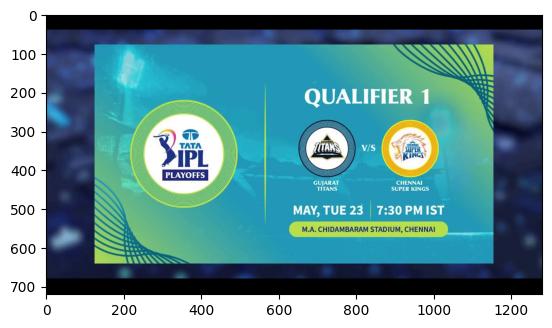

In [12]:
import cv2
import numpy as np
from matplotlib import pyplot as plt

try:
    cap = cv2.VideoCapture(r"E:\Lip_Wise_GFPGAN\_testData\Inputs\small_test.mp4")
except Exception as e:
    print(e)
# no_face_index = np.load(r"E:\Lip_Wise_GFPGAN\temp\npy_files\no_face_index.npy")
# face_index_list = np.load(r"E:\Lip_Wise_GFPGAN\temp\npy_files\face_index_list.npy")

fps = cap.get(cv2.CAP_PROP_FPS)
height = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))
width = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
frame_count = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
batch_size = 500

print(f"fps: {fps}")
print(f"height: {height}")
print(f"width: {width}")
print(f"frame_count: {frame_count}")

try:
    frames = np.zeros((batch_size, height, width, 3), np.dtype('uint8'))
except MemoryError as error:
    print(f"Memory Error: {error}")
    batch_size = 100
    frames = np.zeros((batch_size, height, width, 3), np.dtype('uint8'))

# face_frames = np.empty((batch_size, height, width, 3), np.dtype('uint8'))
i = 0
while True:
    
    ret, frame = cap.read()
    
    if not ret:
        break
    
    frames[i] = frame
    plt.imshow(frames[i][:, :, ::-1])

    print(frames[i])

    # if i in no_face_index and j < batch_size:
    #     frames[j] = frame
    #     print(f"frame: {i}")
    #     j += 1
    # elif i in face_index_list and k < batch_size:
    #     face_frames[k] = frame
    #     print(f"face_frame: {i}")
    #     k += 1

    # if j == batch_size and k == batch_size:
    #     break

    i += 1
    if i == batch_size:
        break

cap.release()
np.save(r"E:\Lip_Wise_GFPGAN\_testData\Outputs\frames.npy", frames)

In [ ]:
imgs = np.load(r"E:\Lip_Wise_GFPGAN\_testData\Outputs\frames.npy")
plt.imshow(imgs[400][:, :, ::-1])
frames_batch = np.array_split(imgs, len(imgs)//4)

for i, batch in enumerate(frames_batch):
    print(f"Batch {i}: {batch.shape}")
    plt.figure(figsize=(10, 10))
    for j, frame in enumerate(batch):
        plt.subplot(2, 2, j+1)
        plt.imshow(frame[:, :, ::-1])
        plt.axis('off')

# IMPORTANT

In [17]:
import batch_processors
import numpy as np
import matplotlib.pyplot as plt
import cv2

# Creating Boolean mask
total_frames = np.arange(0, 500) #500 is frame count
no_face_index = np.load(r"E:\Lip_Wise_GFPGAN\temp\npy_files\no_face_index.npy")

mask = np.isin(total_frames, no_face_index, invert=True).astype(bool)
mask_batch = np.array_split(mask, len(mask)//16, axis=0)

# Load the npy file
frames = np.load(r"E:\Lip_Wise_GFPGAN\_testData\Outputs\frames.npy")
frames_batch = np.array_split(frames, len(frames)//16, axis=0)

print(f"frames_batch_shape: {frames_batch[0].shape}")

frame_numbers = np.arange(0, len(frames))
frame_nos_batch = np.array_split(frame_numbers, len(frames)//16, axis=0)

bp = batch_processors.BatchProcessors(frames, 0, 16, 16)

writer = cv2.VideoWriter(r"E:\Lip_Wise_GFPGAN\_testData\Outputs\output.mp4", cv2.VideoWriter_fourcc(*'mp4v'), 25, (frames.shape[2], frames.shape[1]))

for i in range(len(frames_batch)):
    frame_nos_to_input = frame_nos_batch[i][mask_batch[i]]
    frames_to_input = frames_batch[i][mask_batch[i]]
    if len(frames_to_input) == 0:
        continue
    extracted_faces, original_masks = bp.extract_face_batch(frames_to_input, frame_nos_to_input)
    frames_batch[i][mask_batch[i]] = extracted_faces

for i in range(len(frames_batch)):
    for j in range(len(frames_batch[i])):
        writer.write(frames_batch[i][j])

writer.release()


e:\Lip_Wise_GFPGAN\gan\lib\site-packages\torchvision\transforms\functional_tensor.py:5: UserWarning: The torchvision.transforms.functional_tensor module is deprecated in 0.15 and will be **removed in 0.17**. Please don't rely on it. You probably just need to use APIs in torchvision.transforms.functional or in torchvision.transforms.v2.functional.
  warnings.warn(


frames_batch_shape: (17, 720, 1280, 3)


# <font color=red>IMPORTANT (Code For Processing batch)</font>

#### A boolean mask can be created using no face index and it can be applied into np array to select specific elements of the array, in this case frames with face

In [ ]:
import batch_processors
import numpy as np
import matplotlib.pyplot as plt
import cv2

cap = cv2.VideoCapture(r"E:\Lip_Wise_GFPGAN\_testData\Inputs\small_test.mp4")

# Get video properties
fps = cap.get(cv2.CAP_PROP_FPS)
frame_count = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
width = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
height = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))

# Creating Boolean mask
total_frames = np.arange(0, frame_count) #500 is frame count
no_face_index = np.load(r"E:\Lip_Wise_GFPGAN\temp\npy_files\no_face_index.npy")

mask = np.isin(total_frames, no_face_index, invert=True).astype(bool)
mask_batch = np.array_split(mask, len(mask)//16, axis=0)

writer = cv2.VideoWriter(r"E:\Lip_Wise_GFPGAN\_testData\Outputs\output_grand.mp4", cv2.VideoWriter_fourcc(*'mp4v'), fps, (width, height))

# Create an array of frame numbers
frame_numbers = np.arange(0, frame_count)
frame_nos_batch = np.array_split(frame_numbers, frame_count//16, axis=0)

bp = batch_processors.BatchProcessors()

images = []
batch_no = 0
while True:
    ret, frame = cap.read()

    if not ret:
        break

    frame_no = int(cap.get(cv2.CAP_PROP_POS_FRAMES))
    print(f"Appending Frame no: {frame_no}")
    images.append(frame)

    print(f"len of images: {len(images)}, len of mask_batch: {len(mask_batch[batch_no])}")

    if len(images) == len(mask_batch[batch_no]):
        
        frames = np.array(images)
        frame_nos_to_input = frame_nos_batch[batch_no][mask_batch[batch_no]]
        frames_to_input = frames[mask_batch[batch_no]]
        if len(frames_to_input) != 0:
            extracted_faces, original_masks = bp.extract_face_batch(frames_to_input, frame_nos_to_input)
            frames[mask_batch[batch_no]] = extracted_faces
        print(f"Writing batch no: {batch_no}")
        for frame in frames:
            writer.write(frame)
        batch_no += 1

        images = []

cap.release()
writer.release()

    


In [43]:
import numpy as np

arr = np.array([1, 2, 3, 4, 5, 6, 7, 8, 9, 10])
mask = np.array([0, 1, 1, 0, 0, 1, 1, 1, 0, 0]).astype(bool)

# Multiply elements based on the mask and insert them back into the original array
arr[mask] = arr[mask]*2

print(arr)

[ 1  4  6  4  5 12 14 16  9 10]


In [49]:
import numpy as np

arr1 = np.array([1, 2, 3, 4, 5, 6, 7, 8, 9, 10])
arr2 = np.array([10, 20, 30, 40, 50])
mask = np.array([True, False, True, False, True, True, True, False, False, False])

# Create an iterator for arr2 to cycle through elements
# arr2_iter = iter(arr2)

# Insert elements from arr2 into arr1 where mask is True
# ooo = [next(arr2_iter) for _ in range(mask.sum())]
arr1[mask] = arr2

print(arr1)


[10  2 20  4 30 40 50  8  9 10]


In [50]:
import numpy as np

arr1 = np.array([1, 2, 3, 4, 5, 6, 7, 8, 9, 10])
arr2 = np.array([2, 4, 6, 8])

# Create a boolean mask where common elements are False, others are True
mask = ~np.isin(arr1, arr2)

print(mask)

[ True False  True False  True False  True False  True  True]


In [ ]:
import batch_processors
import numpy as np
import matplotlib.pyplot as plt

# Load the npy file
frames = np.load(r"E:\Lip_Wise_GFPGAN\_testData\Outputs\frames.npy")

bp = batch_processors.BatchProcessors(frames, 0, 16, 16)

frame_nos = np.arange(30, 46)
# Get the first 16 frames_extraction
extracted_faces = bp.extract_face_batch(frames[30:46], frame_nos)

# Check if there are at least 16 frames
if frames.shape[0] < 16:
    raise ValueError('The npy file must contain at least 16 frames.')

# Create a 4x4 grid of subplots
fig, axs = plt.subplots(4, 4)

# Iterate over the first 16 frames
for i in range(4):
    for j in range(4):
        # Plot the frame in the subplot
        axs[i, j].imshow(frames[i*4 + j][:, :, ::-1])
        axs[i, j].axis('off')  # Hide axes

face, face_axs = plt.subplots(4, 4)
for i in range(4):
    for j in range(4):
        # Plot the frame in the subplot
        face_axs[i, j].imshow(extracted_faces[i*4 + j][0][:, :, ::-1])
        face_axs[i, j].axis('off')  # Hide axes

# Display the plot
plt.show()